In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 16a:

## Sequential Model using ionosphere putting it together

1. Monitor validation set as well as training set
2. L2 Regularization
3. Dropouts
4. Batch Norm
5. Early stopping

</p><img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import sys

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from time import time

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler, LabelEncoder

import tensorflow as tf

%matplotlib inline

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-12-09 08:44:00.449199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 08:44:00.527546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 08:44:00.527766: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
def fn_verify_dir(_path):
    '''
    Arg:
        path: path to verify the directory
    returns:
        create dir if it does not exists
    '''
    if os.path.exists(_path): # check if the path exists. Maybe a file or a folder
        
        print(_path, ' exists') # advised the user
        
    else:
        
        os.makedirs(_path) # create the path
        
        print("Created folder : ", _path)

In [8]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'ionosphere'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
 
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 200 # number of epochs
ALPHA = 0.1 # learning rate

BATCH_SIZE = 64 # other sizes leave last batch partial

TRAIN_SIZE = int(BATCH_SIZE*4)

PATIENCE = 10
# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## Helper Functions

In [9]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    hist_df.plot(y = ['loss','val_loss'], ax = ax, colormap=CMAP)

    lossmin = hist_df['loss'].min()

    testmin = hist_df['val_loss'].min()

    # little beautification
    txtstr = "Min Loss: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(lossmin,
                                                                            testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel("Loss")

    ax.grid();

    ax = axes[1]

    hist_df.plot( y = ['accuracy', 'val_accuracy'], ax = ax, colormap=CMAP)
    acc = hist_df['accuracy'].values
    # little beautification
    accmax = hist_df['accuracy'].max()
    testmax = hist_df['val_accuracy'].max()
    txtstr = "Max Accuracy: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(accmax,
                                                                                testmax) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.grid();
    plt.tight_layout()

## Load Data

### Data Set Information:

This radar data was collected by a system in Goose Bay, Labrador. This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts. See the paper for more details. The targets were free electrons in the ionosphere. "Good" radar returns are those showing evidence of some type of structure in the ionosphere. "Bad" returns are those that do not; their signals pass through the ionosphere.

Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number. There were 17 pulse numbers for the Goose Bay system. Instances in this database are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

Attribute Information:

-- All 34 are continuous
-- The 35th attribute is either "good" or "bad" according to the definition summarized above. This is a binary classification task.

We will model this as two class.

In [10]:
data_df = pd.read_csv(os.path.join(inpDir, subDir, 'ionosphere.data'), header = None)
data_df.shape

(351, 35)

In [11]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [12]:
X = data_df.drop(data_df.columns[-1], axis = 1).to_numpy()

y = data_df[data_df.columns[-1]].to_numpy()

In [13]:
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                   train_size = TRAIN_SIZE,
                                                   stratify=y,
                                                   random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((256, 34), (95, 34), (256,), (95,))

In [14]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)

y_test = le.transform(y_test)

In [15]:
class_name = list(le.classes_)
class_name

['b', 'g']

In [16]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [28]:
initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

In [29]:
X_train.shape

(256, 34)

In [30]:
model1 = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense (34,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (24,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (14,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dense (2),
    
])

In [31]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

In [32]:
model1.compile (optimizer = 'Adam',
               loss = loss_fn,
               metrics= ['accuracy'])

In [33]:
histroy = model1.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

Epoch 1/200
4/4 - 0s - loss: 0.6843 - accuracy: 0.6250 - val_loss: 0.7391 - val_accuracy: 0.6211 - 391ms/epoch - 98ms/step
Epoch 2/200
4/4 - 0s - loss: 0.6343 - accuracy: 0.6797 - val_loss: 0.7035 - val_accuracy: 0.6316 - 33ms/epoch - 8ms/step
Epoch 3/200
4/4 - 0s - loss: 0.5936 - accuracy: 0.7227 - val_loss: 0.6741 - val_accuracy: 0.6526 - 30ms/epoch - 7ms/step
Epoch 4/200
4/4 - 0s - loss: 0.5572 - accuracy: 0.7656 - val_loss: 0.6508 - val_accuracy: 0.6632 - 31ms/epoch - 8ms/step
Epoch 5/200
4/4 - 0s - loss: 0.5259 - accuracy: 0.7969 - val_loss: 0.6278 - val_accuracy: 0.6737 - 31ms/epoch - 8ms/step
Epoch 6/200
4/4 - 0s - loss: 0.4958 - accuracy: 0.8320 - val_loss: 0.6063 - val_accuracy: 0.7053 - 29ms/epoch - 7ms/step
Epoch 7/200
4/4 - 0s - loss: 0.4665 - accuracy: 0.8438 - val_loss: 0.5873 - val_accuracy: 0.7158 - 31ms/epoch - 8ms/step
Epoch 8/200
4/4 - 0s - loss: 0.4396 - accuracy: 0.8750 - val_loss: 0.5699 - val_accuracy: 0.7474 - 31ms/epoch - 8ms/step
Epoch 9/200
4/4 - 0s - loss: 0

Epoch 69/200
4/4 - 0s - loss: 0.0265 - accuracy: 0.9961 - val_loss: 0.4948 - val_accuracy: 0.8421 - 25ms/epoch - 6ms/step
Epoch 70/200
4/4 - 0s - loss: 0.0257 - accuracy: 0.9961 - val_loss: 0.4995 - val_accuracy: 0.8421 - 26ms/epoch - 7ms/step
Epoch 71/200
4/4 - 0s - loss: 0.0252 - accuracy: 0.9961 - val_loss: 0.4993 - val_accuracy: 0.8421 - 28ms/epoch - 7ms/step
Epoch 72/200
4/4 - 0s - loss: 0.0243 - accuracy: 0.9961 - val_loss: 0.5052 - val_accuracy: 0.8421 - 26ms/epoch - 7ms/step
Epoch 73/200
4/4 - 0s - loss: 0.0235 - accuracy: 0.9961 - val_loss: 0.5110 - val_accuracy: 0.8421 - 28ms/epoch - 7ms/step
Epoch 74/200
4/4 - 0s - loss: 0.0229 - accuracy: 0.9961 - val_loss: 0.5170 - val_accuracy: 0.8421 - 28ms/epoch - 7ms/step
Epoch 75/200
4/4 - 0s - loss: 0.0223 - accuracy: 0.9961 - val_loss: 0.5173 - val_accuracy: 0.8421 - 28ms/epoch - 7ms/step
Epoch 76/200
4/4 - 0s - loss: 0.0217 - accuracy: 0.9961 - val_loss: 0.5172 - val_accuracy: 0.8421 - 26ms/epoch - 6ms/step
Epoch 77/200
4/4 - 0s - 

Epoch 136/200
4/4 - 0s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.6847 - val_accuracy: 0.8421 - 29ms/epoch - 7ms/step
Epoch 137/200
4/4 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.6916 - val_accuracy: 0.8421 - 25ms/epoch - 6ms/step
Epoch 138/200
4/4 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.6976 - val_accuracy: 0.8421 - 25ms/epoch - 6ms/step
Epoch 139/200
4/4 - 0s - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.6917 - val_accuracy: 0.8421 - 26ms/epoch - 6ms/step
Epoch 140/200
4/4 - 0s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.7012 - val_accuracy: 0.8421 - 25ms/epoch - 6ms/step
Epoch 141/200
4/4 - 0s - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.7101 - val_accuracy: 0.8526 - 23ms/epoch - 6ms/step
Epoch 142/200
4/4 - 0s - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.7115 - val_accuracy: 0.8526 - 27ms/epoch - 7ms/step
Epoch 143/200
4/4 - 0s - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.7083 - val_accuracy: 0.8526 - 26ms/epoch - 6ms/step
Epoch 144/200
4/

In [23]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 34)                1190      
                                                                 
 dense_1 (Dense)             (None, 24)                840       
                                                                 
 dense_2 (Dense)             (None, 14)                350       
                                                                 
 dense_3 (Dense)             (None, 2)                 30        
                                                                 
Total params: 2,410
Trainable params: 2,410
Non-trainable params: 0
_________________________________________________________________


In [34]:
hist_df = pd.DataFrame(histroy.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.684349,0.625000,0.739051,0.621053
1,0.634306,0.679688,0.703498,0.631579
2,0.593642,0.722656,0.674114,0.652632
3,0.557249,0.765625,0.650792,0.663158
4,0.525891,0.796875,0.627760,0.673684


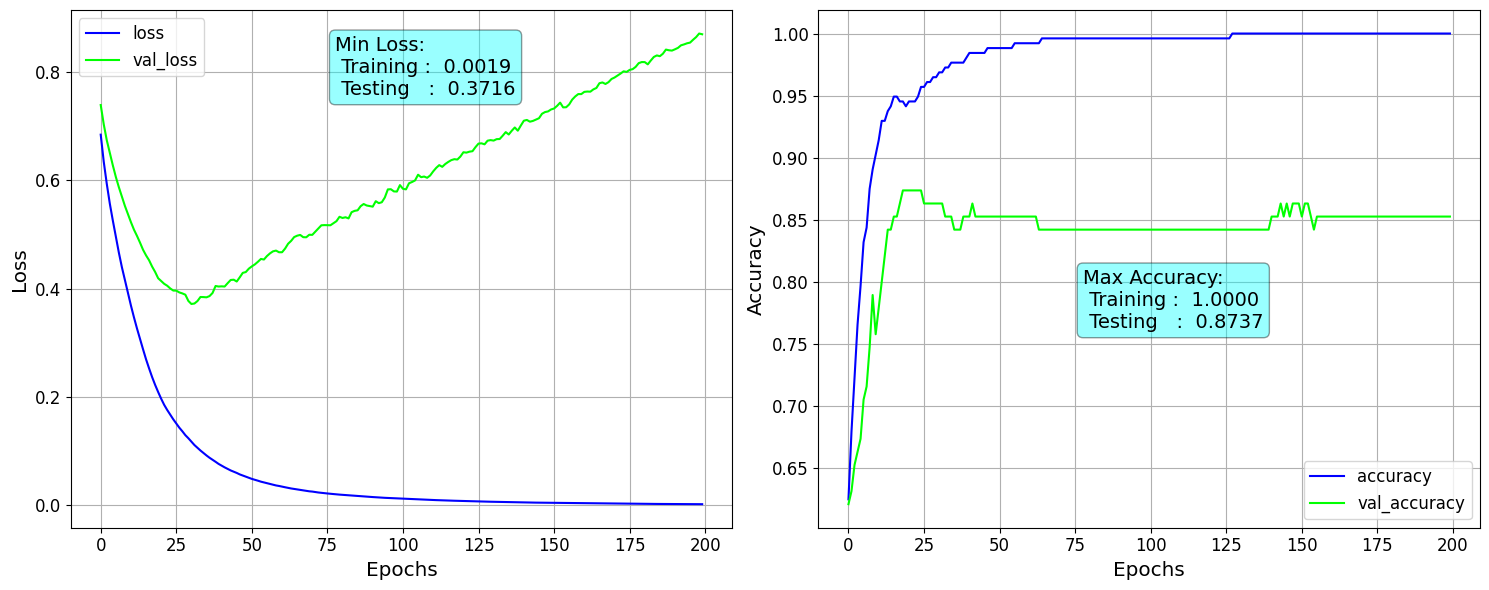

In [35]:
fn_plot_hist(hist_df)

In [43]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
150,0.002997,1.0,0.164351,0.905263


In [36]:
proba_model1 = tf.keras.Sequential([model1,
                                   tf.keras.layers.Softmax()])

y_pred = proba_model1(X_test)

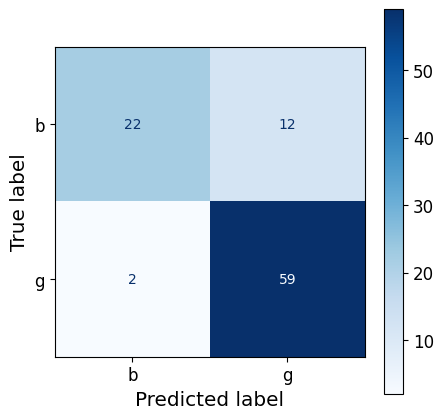

In [37]:
cm = confusion_matrix(y_test, y_pred.numpy().argmax(axis = 1) )

disp = ConfusionMatrixDisplay(confusion_matrix= cm, display_labels=class_name)

fig, ax = plt.subplots(figsize=(5,5))

disp.plot(ax = ax, cmap = plt.cm.Blues);

## L2 Regularizer

In [38]:
initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

regularizer = tf.keras.regularizers.L2(0.02)

model2 = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense (34,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer), # ---- add L2 Regularizer
    
    tf.keras.layers.Dense (24,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),
    
    tf.keras.layers.Dense (14,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),
    
    tf.keras.layers.Dense (2),
    
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model2.compile (optimizer = 'Adam',
               loss = loss_fn,
               metrics= ['accuracy'])


history = model2.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/200
4/4 - 1s - loss: 2.2508 - accuracy: 0.4336 - val_loss: 2.1858 - val_accuracy: 0.6842 - 527ms/epoch - 132ms/step
Epoch 2/200
4/4 - 0s - loss: 2.1728 - accuracy: 0.6875 - val_loss: 2.1179 - val_accuracy: 0.7684 - 32ms/epoch - 8ms/step
Epoch 3/200
4/4 - 0s - loss: 2.1048 - accuracy: 0.8164 - val_loss: 2.0600 - val_accuracy: 0.8211 - 29ms/epoch - 7ms/step
Epoch 4/200
4/4 - 0s - loss: 2.0442 - accuracy: 0.8633 - val_loss: 2.0052 - val_accuracy: 0.8316 - 34ms/epoch - 9ms/step
Epoch 5/200
4/4 - 0s - loss: 1.9853 - accuracy: 0.8750 - val_loss: 1.9504 - val_accuracy: 0.8632 - 32ms/epoch - 8ms/step
Epoch 6/200
4/4 - 0s - loss: 1.9269 - accuracy: 0.8828 - val_loss: 1.8967 - val_accuracy: 0.8632 - 31ms/epoch - 8ms/step
Epoch 7/200
4/4 - 0s - loss: 1.8701 - accuracy: 0.8984 - val_loss: 1.8430 - val_accuracy: 0.8737 - 33ms/epoch - 8ms/step
Epoch 8/200
4/4 - 0s - loss: 1.8140 - accuracy: 0.9062 - val_loss: 1.7898 - val_accuracy: 0.8842 - 37ms/epoch - 9ms/step
Epoch 9/200
4/4 - 0s - loss: 

Epoch 69/200
4/4 - 0s - loss: 0.3941 - accuracy: 0.9688 - val_loss: 0.5474 - val_accuracy: 0.8737 - 29ms/epoch - 7ms/step
Epoch 70/200
4/4 - 0s - loss: 0.3875 - accuracy: 0.9688 - val_loss: 0.5441 - val_accuracy: 0.8737 - 30ms/epoch - 7ms/step
Epoch 71/200
4/4 - 0s - loss: 0.3811 - accuracy: 0.9688 - val_loss: 0.5389 - val_accuracy: 0.8737 - 29ms/epoch - 7ms/step
Epoch 72/200
4/4 - 0s - loss: 0.3749 - accuracy: 0.9688 - val_loss: 0.5355 - val_accuracy: 0.8737 - 30ms/epoch - 8ms/step
Epoch 73/200
4/4 - 0s - loss: 0.3689 - accuracy: 0.9688 - val_loss: 0.5304 - val_accuracy: 0.8737 - 29ms/epoch - 7ms/step
Epoch 74/200
4/4 - 0s - loss: 0.3629 - accuracy: 0.9688 - val_loss: 0.5261 - val_accuracy: 0.8737 - 29ms/epoch - 7ms/step
Epoch 75/200
4/4 - 0s - loss: 0.3575 - accuracy: 0.9688 - val_loss: 0.5192 - val_accuracy: 0.8842 - 30ms/epoch - 7ms/step
Epoch 76/200
4/4 - 0s - loss: 0.3518 - accuracy: 0.9688 - val_loss: 0.5153 - val_accuracy: 0.8842 - 30ms/epoch - 7ms/step
Epoch 77/200
4/4 - 0s - 

Epoch 136/200
4/4 - 0s - loss: 0.2049 - accuracy: 0.9883 - val_loss: 0.4259 - val_accuracy: 0.8947 - 24ms/epoch - 6ms/step
Epoch 137/200
4/4 - 0s - loss: 0.2041 - accuracy: 0.9883 - val_loss: 0.4251 - val_accuracy: 0.8947 - 24ms/epoch - 6ms/step
Epoch 138/200
4/4 - 0s - loss: 0.2030 - accuracy: 0.9883 - val_loss: 0.4233 - val_accuracy: 0.8947 - 25ms/epoch - 6ms/step
Epoch 139/200
4/4 - 0s - loss: 0.2021 - accuracy: 0.9883 - val_loss: 0.4217 - val_accuracy: 0.8947 - 25ms/epoch - 6ms/step
Epoch 140/200
4/4 - 0s - loss: 0.2014 - accuracy: 0.9883 - val_loss: 0.4263 - val_accuracy: 0.8947 - 24ms/epoch - 6ms/step
Epoch 141/200
4/4 - 0s - loss: 0.2005 - accuracy: 0.9883 - val_loss: 0.4278 - val_accuracy: 0.8947 - 25ms/epoch - 6ms/step
Epoch 142/200
4/4 - 0s - loss: 0.1996 - accuracy: 0.9883 - val_loss: 0.4255 - val_accuracy: 0.8947 - 25ms/epoch - 6ms/step
Epoch 143/200
4/4 - 0s - loss: 0.1986 - accuracy: 0.9883 - val_loss: 0.4234 - val_accuracy: 0.8947 - 24ms/epoch - 6ms/step
Epoch 144/200
4/

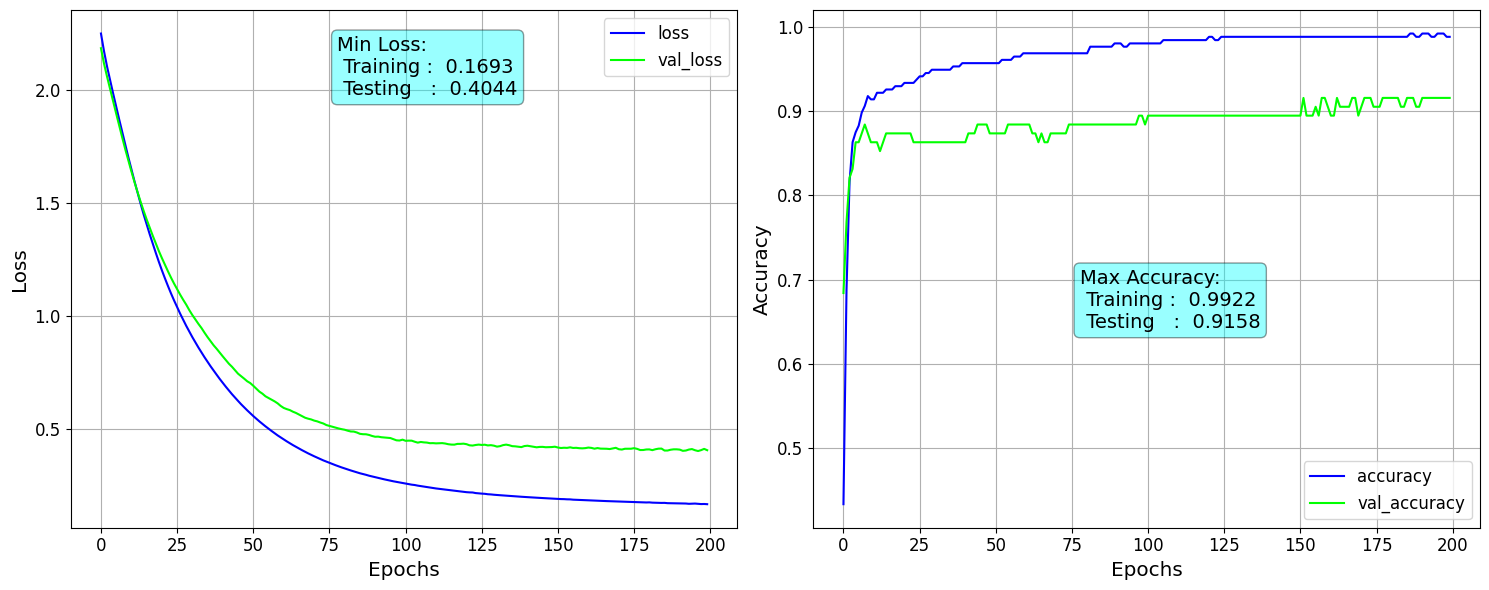

In [39]:
fn_plot_hist(hist_df)

## Batch Normalization

In [40]:
initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

model3 = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense (34,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer
                           ),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense (24,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense (14,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense (2),
    
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model3.compile (optimizer = 'Adam',
               loss = loss_fn,
               metrics= ['accuracy'])


history = model3.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/200
4/4 - 1s - loss: 0.9654 - accuracy: 0.5391 - val_loss: 0.7815 - val_accuracy: 0.4632 - 766ms/epoch - 192ms/step
Epoch 2/200
4/4 - 0s - loss: 0.7964 - accuracy: 0.6094 - val_loss: 0.7274 - val_accuracy: 0.5158 - 37ms/epoch - 9ms/step
Epoch 3/200
4/4 - 0s - loss: 0.6521 - accuracy: 0.6875 - val_loss: 0.6782 - val_accuracy: 0.5895 - 36ms/epoch - 9ms/step
Epoch 4/200
4/4 - 0s - loss: 0.5284 - accuracy: 0.7422 - val_loss: 0.6335 - val_accuracy: 0.6421 - 35ms/epoch - 9ms/step
Epoch 5/200
4/4 - 0s - loss: 0.4572 - accuracy: 0.7773 - val_loss: 0.5931 - val_accuracy: 0.7474 - 38ms/epoch - 10ms/step
Epoch 6/200
4/4 - 0s - loss: 0.4101 - accuracy: 0.8281 - val_loss: 0.5583 - val_accuracy: 0.8000 - 35ms/epoch - 9ms/step
Epoch 7/200
4/4 - 0s - loss: 0.3459 - accuracy: 0.8555 - val_loss: 0.5270 - val_accuracy: 0.8211 - 38ms/epoch - 10ms/step
Epoch 8/200
4/4 - 0s - loss: 0.3112 - accuracy: 0.8867 - val_loss: 0.4983 - val_accuracy: 0.8421 - 35ms/epoch - 9ms/step
Epoch 9/200
4/4 - 0s - loss

Epoch 69/200
4/4 - 0s - loss: 0.0214 - accuracy: 0.9961 - val_loss: 0.1940 - val_accuracy: 0.9053 - 30ms/epoch - 7ms/step
Epoch 70/200
4/4 - 0s - loss: 0.0165 - accuracy: 1.0000 - val_loss: 0.1933 - val_accuracy: 0.9158 - 31ms/epoch - 8ms/step
Epoch 71/200
4/4 - 0s - loss: 0.0205 - accuracy: 0.9961 - val_loss: 0.1913 - val_accuracy: 0.9158 - 30ms/epoch - 8ms/step
Epoch 72/200
4/4 - 0s - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.1895 - val_accuracy: 0.9158 - 29ms/epoch - 7ms/step
Epoch 73/200
4/4 - 0s - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.1882 - val_accuracy: 0.9158 - 30ms/epoch - 8ms/step
Epoch 74/200
4/4 - 0s - loss: 0.0317 - accuracy: 0.9961 - val_loss: 0.1866 - val_accuracy: 0.9158 - 29ms/epoch - 7ms/step
Epoch 75/200
4/4 - 0s - loss: 0.0239 - accuracy: 0.9961 - val_loss: 0.1850 - val_accuracy: 0.9158 - 29ms/epoch - 7ms/step
Epoch 76/200
4/4 - 0s - loss: 0.0212 - accuracy: 0.9961 - val_loss: 0.1858 - val_accuracy: 0.9158 - 29ms/epoch - 7ms/step
Epoch 77/200
4/4 - 0s - 

Epoch 136/200
4/4 - 0s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.1710 - val_accuracy: 0.9053 - 30ms/epoch - 7ms/step
Epoch 137/200
4/4 - 0s - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1712 - val_accuracy: 0.9053 - 30ms/epoch - 7ms/step
Epoch 138/200
4/4 - 0s - loss: 0.0066 - accuracy: 1.0000 - val_loss: 0.1725 - val_accuracy: 0.8947 - 29ms/epoch - 7ms/step
Epoch 139/200
4/4 - 0s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.1743 - val_accuracy: 0.8947 - 29ms/epoch - 7ms/step
Epoch 140/200
4/4 - 0s - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.1739 - val_accuracy: 0.8947 - 28ms/epoch - 7ms/step
Epoch 141/200
4/4 - 0s - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.1757 - val_accuracy: 0.8947 - 30ms/epoch - 7ms/step
Epoch 142/200
4/4 - 0s - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1806 - val_accuracy: 0.8947 - 30ms/epoch - 7ms/step
Epoch 143/200
4/4 - 0s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.1803 - val_accuracy: 0.8947 - 29ms/epoch - 7ms/step
Epoch 144/200
4/

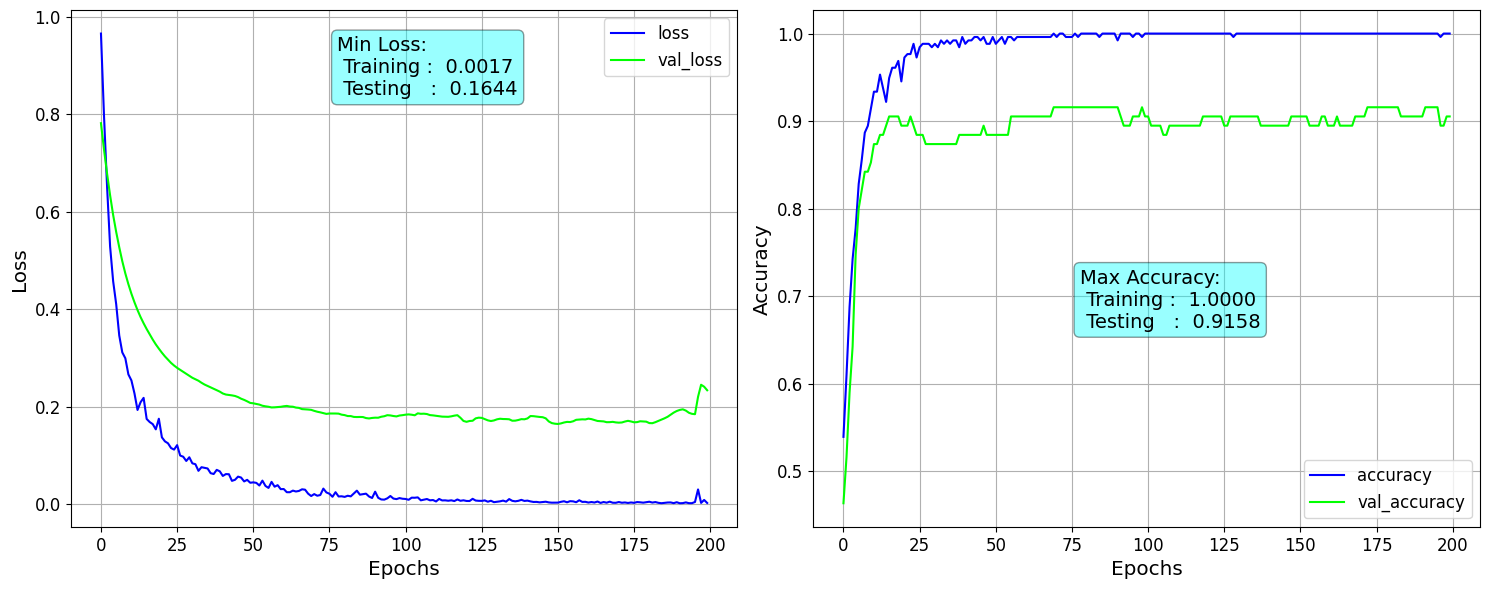

In [41]:
fn_plot_hist(hist_df)

In [42]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
150,0.002997,1.0,0.164351,0.905263


## DROP OUTS

In [45]:
initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

rate = 0.05

model4 = tf.keras.models.Sequential([
    
    tf.keras.layers.Dense (34,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer
                           ),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (24,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (14,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model4.compile (optimizer = 'Adam',
               loss = loss_fn,
               metrics= ['accuracy'])


history = model4.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2)

hist_df = pd.DataFrame(history.history)

Epoch 1/200
4/4 - 0s - loss: 0.7080 - accuracy: 0.4609 - val_loss: 0.6924 - val_accuracy: 0.4316 - 444ms/epoch - 111ms/step
Epoch 2/200
4/4 - 0s - loss: 0.6594 - accuracy: 0.5117 - val_loss: 0.6469 - val_accuracy: 0.5895 - 32ms/epoch - 8ms/step
Epoch 3/200
4/4 - 0s - loss: 0.6052 - accuracy: 0.6758 - val_loss: 0.6099 - val_accuracy: 0.7579 - 32ms/epoch - 8ms/step
Epoch 4/200
4/4 - 0s - loss: 0.5675 - accuracy: 0.7969 - val_loss: 0.5781 - val_accuracy: 0.8000 - 34ms/epoch - 8ms/step
Epoch 5/200
4/4 - 0s - loss: 0.5397 - accuracy: 0.8242 - val_loss: 0.5497 - val_accuracy: 0.8211 - 33ms/epoch - 8ms/step
Epoch 6/200
4/4 - 0s - loss: 0.5091 - accuracy: 0.8594 - val_loss: 0.5260 - val_accuracy: 0.8211 - 31ms/epoch - 8ms/step
Epoch 7/200
4/4 - 0s - loss: 0.4536 - accuracy: 0.8594 - val_loss: 0.5064 - val_accuracy: 0.8211 - 32ms/epoch - 8ms/step
Epoch 8/200
4/4 - 0s - loss: 0.4369 - accuracy: 0.8633 - val_loss: 0.4912 - val_accuracy: 0.8211 - 36ms/epoch - 9ms/step
Epoch 9/200
4/4 - 0s - loss: 

Epoch 69/200
4/4 - 0s - loss: 0.0458 - accuracy: 0.9883 - val_loss: 0.3368 - val_accuracy: 0.8947 - 29ms/epoch - 7ms/step
Epoch 70/200
4/4 - 0s - loss: 0.0481 - accuracy: 0.9922 - val_loss: 0.3305 - val_accuracy: 0.8947 - 27ms/epoch - 7ms/step
Epoch 71/200
4/4 - 0s - loss: 0.0552 - accuracy: 0.9844 - val_loss: 0.3249 - val_accuracy: 0.8947 - 30ms/epoch - 8ms/step
Epoch 72/200
4/4 - 0s - loss: 0.0509 - accuracy: 0.9883 - val_loss: 0.3229 - val_accuracy: 0.9053 - 32ms/epoch - 8ms/step
Epoch 73/200
4/4 - 0s - loss: 0.0600 - accuracy: 0.9766 - val_loss: 0.3206 - val_accuracy: 0.9158 - 31ms/epoch - 8ms/step
Epoch 74/200
4/4 - 0s - loss: 0.0488 - accuracy: 0.9844 - val_loss: 0.3214 - val_accuracy: 0.9158 - 30ms/epoch - 8ms/step
Epoch 75/200
4/4 - 0s - loss: 0.0485 - accuracy: 0.9844 - val_loss: 0.3219 - val_accuracy: 0.9158 - 31ms/epoch - 8ms/step
Epoch 76/200
4/4 - 0s - loss: 0.0475 - accuracy: 0.9883 - val_loss: 0.3271 - val_accuracy: 0.8947 - 35ms/epoch - 9ms/step
Epoch 77/200
4/4 - 0s - 

Epoch 136/200
4/4 - 0s - loss: 0.0184 - accuracy: 0.9961 - val_loss: 0.3251 - val_accuracy: 0.9158 - 27ms/epoch - 7ms/step
Epoch 137/200
4/4 - 0s - loss: 0.0235 - accuracy: 0.9922 - val_loss: 0.3284 - val_accuracy: 0.9053 - 27ms/epoch - 7ms/step
Epoch 138/200
4/4 - 0s - loss: 0.0169 - accuracy: 0.9961 - val_loss: 0.3272 - val_accuracy: 0.9053 - 26ms/epoch - 6ms/step
Epoch 139/200
4/4 - 0s - loss: 0.0166 - accuracy: 0.9961 - val_loss: 0.3218 - val_accuracy: 0.9053 - 26ms/epoch - 7ms/step
Epoch 140/200
4/4 - 0s - loss: 0.0238 - accuracy: 0.9922 - val_loss: 0.3232 - val_accuracy: 0.9158 - 28ms/epoch - 7ms/step
Epoch 141/200
4/4 - 0s - loss: 0.0177 - accuracy: 0.9961 - val_loss: 0.3161 - val_accuracy: 0.9158 - 28ms/epoch - 7ms/step
Epoch 142/200
4/4 - 0s - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.3094 - val_accuracy: 0.9158 - 25ms/epoch - 6ms/step
Epoch 143/200
4/4 - 0s - loss: 0.0187 - accuracy: 0.9922 - val_loss: 0.3159 - val_accuracy: 0.9158 - 27ms/epoch - 7ms/step
Epoch 144/200
4/

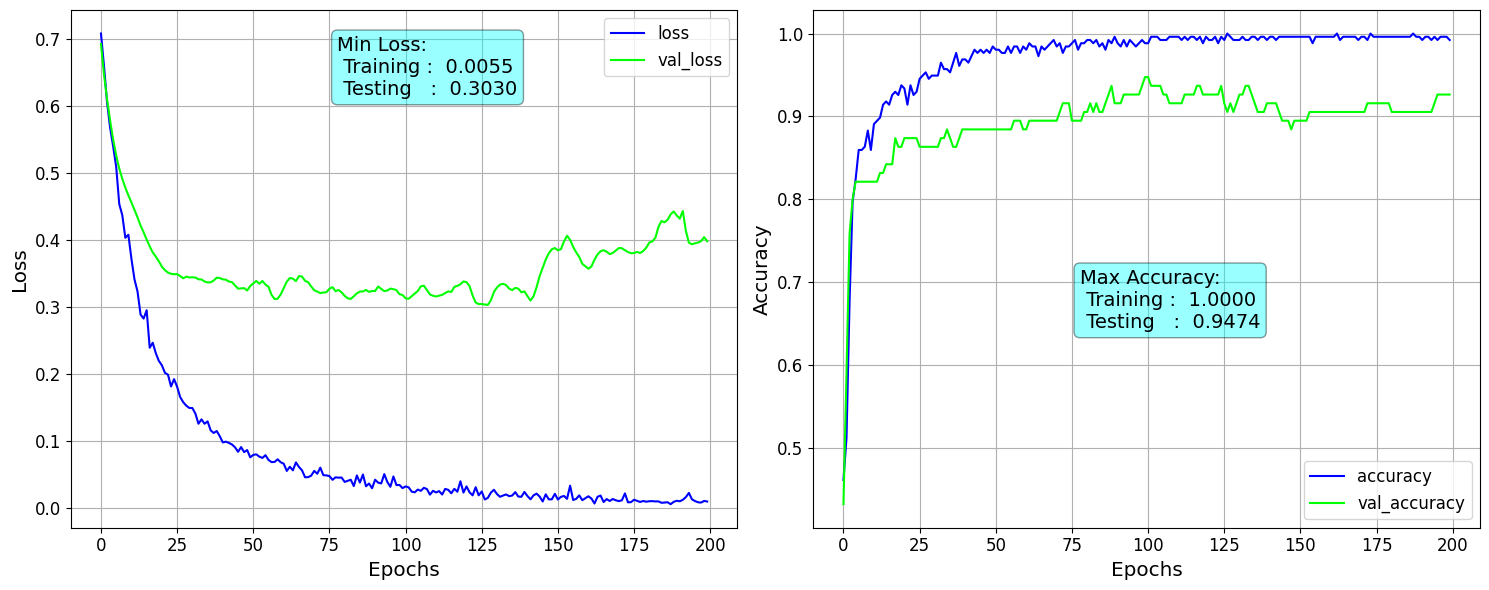

In [46]:
fn_plot_hist(hist_df)

In [47]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
127,0.014972,0.996094,0.30304,0.915789


### All In

In [49]:
initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

rate = 0.05

model = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34, ) ), #### 
    
    tf.keras.layers.Dense (34,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (24,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (14,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model.compile (optimizer = 'Adam',
               loss = loss_fn,
               metrics= ['accuracy'])

In [50]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'weights_all_in')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    save_best_only = True
)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    baseline =None,
    restore_best_weights=True)


In [51]:
history = model.fit( x = X_train, 
                     y= y_train,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    verbose = 2,
                    callbacks = [early_stopping_callback, model_checkpoint_callback])

hist_df = pd.DataFrame(history.history)

Epoch 1/200
4/4 - 1s - loss: 2.6426 - accuracy: 0.4258 - val_loss: 2.2300 - val_accuracy: 0.6842 - 800ms/epoch - 200ms/step
Epoch 2/200
4/4 - 0s - loss: 2.4674 - accuracy: 0.4727 - val_loss: 2.1970 - val_accuracy: 0.7053 - 63ms/epoch - 16ms/step
Epoch 3/200
4/4 - 0s - loss: 2.2828 - accuracy: 0.5938 - val_loss: 2.1649 - val_accuracy: 0.7263 - 56ms/epoch - 14ms/step
Epoch 4/200
4/4 - 0s - loss: 2.2410 - accuracy: 0.6406 - val_loss: 2.1317 - val_accuracy: 0.7474 - 60ms/epoch - 15ms/step
Epoch 5/200
4/4 - 0s - loss: 2.1111 - accuracy: 0.7500 - val_loss: 2.0983 - val_accuracy: 0.8000 - 57ms/epoch - 14ms/step
Epoch 6/200
4/4 - 0s - loss: 2.0599 - accuracy: 0.7461 - val_loss: 2.0659 - val_accuracy: 0.8105 - 56ms/epoch - 14ms/step
Epoch 7/200
4/4 - 0s - loss: 1.9767 - accuracy: 0.7930 - val_loss: 2.0340 - val_accuracy: 0.8105 - 56ms/epoch - 14ms/step
Epoch 8/200
4/4 - 0s - loss: 1.9443 - accuracy: 0.7852 - val_loss: 2.0024 - val_accuracy: 0.8211 - 59ms/epoch - 15ms/step
Epoch 9/200
4/4 - 0s -

Epoch 68/200
4/4 - 0s - loss: 0.5559 - accuracy: 0.9922 - val_loss: 0.7589 - val_accuracy: 0.8737 - 49ms/epoch - 12ms/step
Epoch 69/200
4/4 - 0s - loss: 0.5330 - accuracy: 0.9961 - val_loss: 0.7463 - val_accuracy: 0.8947 - 50ms/epoch - 13ms/step
Epoch 70/200
4/4 - 0s - loss: 0.5204 - accuracy: 0.9922 - val_loss: 0.7352 - val_accuracy: 0.8947 - 55ms/epoch - 14ms/step
Epoch 71/200
4/4 - 0s - loss: 0.5118 - accuracy: 0.9961 - val_loss: 0.7257 - val_accuracy: 0.8947 - 50ms/epoch - 12ms/step
Epoch 72/200
4/4 - 0s - loss: 0.5126 - accuracy: 0.9883 - val_loss: 0.7169 - val_accuracy: 0.8947 - 50ms/epoch - 12ms/step
Epoch 73/200
4/4 - 0s - loss: 0.4959 - accuracy: 0.9961 - val_loss: 0.7091 - val_accuracy: 0.9053 - 53ms/epoch - 13ms/step
Epoch 74/200
4/4 - 0s - loss: 0.4841 - accuracy: 1.0000 - val_loss: 0.7012 - val_accuracy: 0.8947 - 52ms/epoch - 13ms/step
Epoch 75/200
4/4 - 0s - loss: 0.4752 - accuracy: 0.9922 - val_loss: 0.6882 - val_accuracy: 0.8947 - 52ms/epoch - 13ms/step
Epoch 76/200
4/4

Epoch 135/200
4/4 - 0s - loss: 0.1760 - accuracy: 0.9883 - val_loss: 0.4613 - val_accuracy: 0.8842 - 30ms/epoch - 7ms/step
Epoch 136/200
4/4 - 0s - loss: 0.1793 - accuracy: 0.9805 - val_loss: 0.4373 - val_accuracy: 0.8737 - 30ms/epoch - 7ms/step
Epoch 137/200
4/4 - 0s - loss: 0.1587 - accuracy: 0.9961 - val_loss: 0.4153 - val_accuracy: 0.8842 - 50ms/epoch - 13ms/step
Epoch 138/200
4/4 - 0s - loss: 0.1597 - accuracy: 0.9922 - val_loss: 0.3928 - val_accuracy: 0.8842 - 52ms/epoch - 13ms/step
Epoch 139/200
4/4 - 0s - loss: 0.1615 - accuracy: 0.9922 - val_loss: 0.3791 - val_accuracy: 0.9053 - 49ms/epoch - 12ms/step
Epoch 140/200
4/4 - 0s - loss: 0.1486 - accuracy: 1.0000 - val_loss: 0.3780 - val_accuracy: 0.8947 - 51ms/epoch - 13ms/step
Epoch 141/200
4/4 - 0s - loss: 0.1598 - accuracy: 0.9922 - val_loss: 0.3702 - val_accuracy: 0.8947 - 53ms/epoch - 13ms/step
Epoch 142/200
4/4 - 0s - loss: 0.1441 - accuracy: 1.0000 - val_loss: 0.3723 - val_accuracy: 0.9053 - 29ms/epoch - 7ms/step
Epoch 143/2

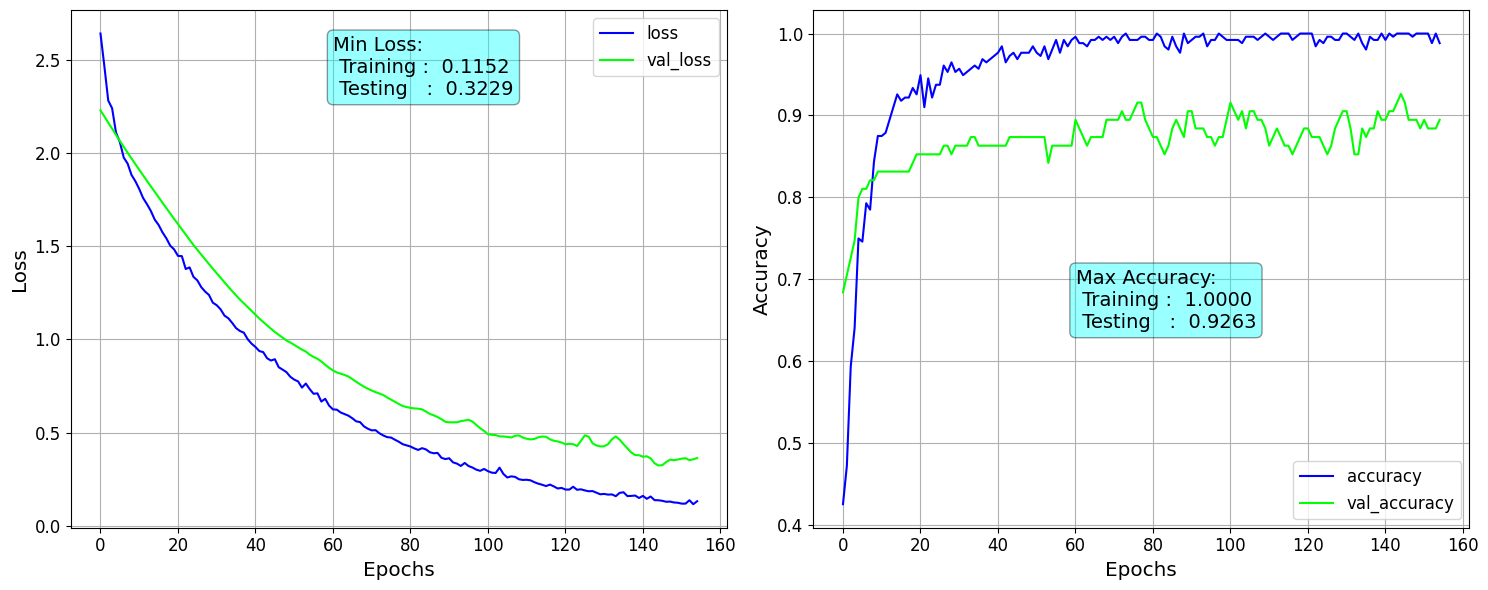

In [52]:
fn_plot_hist(hist_df)

In [53]:
loss_dict = model.evaluate(X_test, y_test, verbose=1 , return_dict=True)

3/3 [==============================] - 0s 2ms/step - loss: 0.3229 - accuracy: 0.9263


In [54]:
loss_dict

{'loss': 0.32293054461479187, 'accuracy': 0.9263157844543457}

In [55]:
hist_df[hist_df['val_loss'] == hist_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
144,0.136263,1.0,0.322931,0.926316


In [56]:
del model
del model1
del model2
del model3
del model4

In [57]:
initalizer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

rate = 0.05

model = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer( input_shape =(34, ) ), #### 
    
    tf.keras.layers.Dense (34,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (24,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (14,
                           activation = tf.keras.activations.relu,
                           kernel_initializer = initalizer,
                           kernel_regularizer = regularizer),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dropout(rate , seed = RANDOM_STATE),
    
    tf.keras.layers.Dense (2),
    
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy( from_logits = True)

model.compile (optimizer = 'Adam',
               loss = loss_fn,
               metrics= ['accuracy'])

In [58]:
res = model.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

3/3 - 1s - loss: 2.3061 - accuracy: 0.3368 - 636ms/epoch - 212ms/step


0.3368421196937561

In [59]:
model.load_weights(checkpoint_filepath)

In [60]:
res = model.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

3/3 - 0s - loss: 0.3229 - accuracy: 0.9263 - 21ms/epoch - 7ms/step


0.9263157844543457

## Save Complete Model

In [61]:
model_path = os.path.join(modelDir, subDir, 'complete_all_in')

tf.keras.models.save_model(model, model_path)

INFO:tensorflow:Assets written to: ../models/ionosphere/complete_all_in/assets


In [62]:
model1 = tf.keras.models.load_model(model_path)

In [63]:
res = model1.evaluate(X_test, y_test, verbose=2, return_dict=True)

res['accuracy']

3/3 - 0s - loss: 0.3229 - accuracy: 0.9263 - 142ms/epoch - 47ms/step


0.9263157844543457

In [64]:
model1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 34)                1190      
                                                                 
 batch_normalization_9 (Batc  (None, 34)               136       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 34)                0         
                                                                 
 dense_33 (Dense)            (None, 24)                840       
                                                                 
 batch_normalization_10 (Bat  (None, 24)               96        
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 24)              